In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import pickle

In [2]:
def read_excel(path):
    return pd.read_excel(path)

In [3]:
path_1 = '../Data/Preprocessing/Data Losarang/2022/1_input_losarang_2022.xlsx'
path_2 = '../Data/Preprocessing/Data Losarang/2022/1_missing_times_losarang_2022.xlsx'

data_terisi = read_excel(path_1)
data_kosong = read_excel(path_2)

In [4]:
data_terisi.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2022-01-01 00:00:00,2022,1,1,1,Saturday,00:00,185,39,24,248,148.0,39,60.0,247
1,2022-01-01 00:15:00,2022,1,1,1,Saturday,00:15,195,64,35,294,156.0,64,87.5,308
2,2022-01-01 00:30:00,2022,1,1,1,Saturday,00:30,194,49,17,260,155.2,49,42.5,247
3,2022-01-01 00:45:00,2022,1,1,1,Saturday,00:45,162,43,21,226,129.6,43,52.5,225
4,2022-01-01 01:00:00,2022,1,1,1,Saturday,01:00,125,58,18,201,100.0,58,45.0,203


In [5]:
# Menghitung IQR dan menghilangkan outlier untuk setiap kombinasi hari dan jam
def remove_outliers(df, column):
    # Mengelompokkan data berdasarkan 'HARI' dan 'JAM'
    grouped = df.groupby(['HARI', 'JAM'])

    # Fungsi untuk menghitung batas dan memfilter outlier
    def filter_outliers(sub_df):
        Q1 = sub_df[column].quantile(0.25)
        Q3 = sub_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return sub_df[(sub_df[column] >= lower_bound) & (sub_df[column] <= upper_bound)]
    
    # Menerapkan filter outlier ke setiap grup
    return grouped.apply(filter_outliers).reset_index(drop=True)

In [6]:
a = len(data_terisi)
# Kolom untuk dibersihkan dari outlier, misal 'MOTOR'
data_terisi = remove_outliers(data_terisi, 'SMP')
b = len(data_terisi)

In [7]:
print(a, b, a-b)

29893 28547 1346


In [8]:
data_kosong.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2022-01-04 19:15:00,2022,1,1,4,Tuesday,19:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-04 19:30:00,2022,1,1,4,Tuesday,19:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-11 18:30:00,2022,1,2,11,Tuesday,18:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-01-11 18:45:00,2022,1,2,11,Tuesday,18:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-01-11 19:00:00,2022,1,2,11,Tuesday,19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Menggabungkan data
data = data_terisi.copy()

In [10]:
# Preprocessing
encoder = OneHotEncoder(sparse_output=False)
scaled_features = StandardScaler()

In [11]:
# Misal meng-encode fitur 'HARI'
encoded_days = encoder.fit_transform(data_terisi[['HARI']])

In [12]:
# Konversi 'JAM' ke total menit sejak tengah malam
data['JAM'] = data_terisi['JAM'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [13]:
# Skala fitur 'JAM', 'MOBIL', 'TRUK/BUS'
scaled_features = scaled_features.fit_transform(data[['JAM', 'MOTOR', 'MOBIL']])

In [14]:
data.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,HARI,JAM,MOTOR,MOBIL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,SMP
0,2022-01-07,2022,1,1,7,Friday,0,35,108,56,199,28.0,108,140.0,276
1,2022-01-14,2022,1,2,14,Friday,0,45,92,61,198,36.0,92,152.5,280
2,2022-01-21,2022,1,3,21,Friday,0,35,100,63,198,28.0,100,157.5,286
3,2022-01-28,2022,1,4,28,Friday,0,28,55,48,131,22.4,55,120.0,197
4,2022-02-04,2022,2,1,4,Friday,0,7,31,30,68,5.6,31,75.0,112


In [15]:
# Gabungkan kembali ke DataFrame
encoded_days = pd.DataFrame(encoded_days, columns=encoder.get_feature_names_out(['HARI']))
scaled_features = pd.DataFrame(scaled_features, columns=['JAM', 'MOTOR', 'MOBIL'])
data_preprocessed = pd.concat([data.drop(['HARI', 'JAM', 'MOTOR', 'MOBIL'], axis=1), encoded_days, scaled_features], axis=1)

In [16]:
data_preprocessed.head()

,WAKTU,TAHUN,BULAN,PEKAN,TANGGAL,TRUK/BUS,JUMLAH,SMP_MTR,SMP_MBL,SMP_TRK,...,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM,MOTOR,MOBIL
0,2022-01-07,2022,1,1,7,56,199,28.0,108,140.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.70998,-1.097219,1.738338
1,2022-01-14,2022,1,2,14,61,198,36.0,92,152.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.70998,-0.973475,1.068473
2,2022-01-21,2022,1,3,21,63,198,28.0,100,157.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.70998,-1.097219,1.403405
3,2022-01-28,2022,1,4,28,48,131,22.4,55,120.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.70998,-1.183840,-0.480589
4,2022-02-04,2022,2,1,4,30,68,5.6,31,75.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.70998,-1.443704,-1.485386


# Prediksi Truk/Bus

In [17]:
# Bagi data menjadi fitur dan target
X = data_preprocessed.drop(['TAHUN', 'WAKTU','TANGGAL','MOTOR','MOBIL','TRUK/BUS','JUMLAH','SMP_MTR','SMP_MBL','SMP_TRK', 'SMP','BULAN','PEKAN'], axis=1)
y = data_preprocessed['TRUK/BUS']

In [18]:
# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train

,HARI_Friday,HARI_Monday,HARI_Saturday,HARI_Sunday,HARI_Thursday,HARI_Tuesday,HARI_Wednesday,JAM
9517,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.592932
1812,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.232594
383,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.421710
13520,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.773101
729,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.133439
...,...,...,...,...,...,...,...,...
21575,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.881203
5390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.628966
860,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.025338
15795,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.172723


In [20]:
y_train

9517      65
1812      58
383       16
13520     73
729       29
        ... 
21575    103
5390      51
860       32
15795     24
23654     51
Name: TRUK/BUS, Length: 22837, dtype: int64

In [21]:
mses = {}
maes = {}
rmses = {}
r2s  = {}

# Rata-rata hari dan jam

In [22]:
data_terisi_train = data_terisi.loc[X_train.index]
data_terisi_test = data_terisi.loc[X_test.index]
len(data_terisi_train), len(data_terisi_test), len(data_terisi_train) + len(data_terisi_test)

(22837, 5710, 28547)

In [23]:
def precompute_means(df):
    # Calculate the mean values for each combination of 'PEKAN', 'HARI', and 'JAM'
    grouped = df.groupby(['HARI', 'JAM'])[['MOTOR', 'MOBIL', 'TRUK/BUS']].mean().reset_index()
    return grouped

def find_imputation(precomputed_means, HARI, JAM):
    # Filter the precomputed means DataFrame for the given day and hour
    result = precomputed_means[(precomputed_means['HARI'] == HARI) & (precomputed_means['JAM'] == JAM)]
    return result if not result.empty else pd.DataFrame()

# Assuming data_terisi is the DataFrame from which you want to impute data
precomputed_means = precompute_means(data_terisi_train)

In [24]:
# Iterate over each row in df_missing and fill in values from precomputed means
df_missing = data_terisi_test.copy()
df_missing['MOTOR_ORI'] = df_missing['MOTOR'] 
df_missing['MOBIL_ORI'] = df_missing['MOBIL'] 
df_missing['TRUK/BUS_ORI'] = df_missing['TRUK/BUS'] 
df_missing['MOTOR'] = np.nan
for i, row in df_missing.iterrows():
    if pd.isna(row['MOTOR']):  # Check if MOTOR is NaN
        imputation = find_imputation(precomputed_means, row['HARI'], row['JAM'])
        if not imputation.empty:
            df_missing.at[i, 'MOTOR'] = imputation['MOTOR'].iloc[0]
            df_missing.at[i, 'MOBIL'] = imputation['MOBIL'].iloc[0]
            df_missing.at[i, 'TRUK/BUS'] = imputation['TRUK/BUS'].iloc[0]

In [25]:
y_pred = df_missing['MOBIL']
y_ori = df_missing['MOBIL_ORI']

# Menghitung MAE
mae = mean_absolute_error(y_ori, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_ori, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_ori, y_pred)
print("R-squared:", r2)

mses["avg"] = mse
maes["avg"] = mae
rmses["avg"] = rmse
r2s["avg"] = r2

Mean Absolute Error (MAE): 12.970863052275499
Mean Squared Error (MSE): 367.5399037354029
Root Mean Squared Error (RMSE): 19.171330254716363
R-squared: 0.39227207111799967


In [26]:
df_missing[['MOTOR_ORI','MOTOR','MOBIL_ORI','MOBIL','TRUK/BUS_ORI','TRUK/BUS']].head()

,MOTOR_ORI,MOTOR,MOBIL_ORI,MOBIL,TRUK/BUS_ORI,TRUK/BUS
9805,208,202.371429,76,79.857143,89,84.000000
9165,49,93.888889,37,67.222222,14,63.111111
8094,19,43.000000,51,62.575758,40,48.606061
2508,144,191.793103,77,90.689655,83,88.310345
96,45,37.818182,50,58.333333,44,48.393939


In [27]:
data_avg = df_missing.rename(columns={'MOBIL': 'Predicted_avg', 'MOBIL_ORI': 'Actual'})
data_avg = data_avg[['Actual','Predicted_avg']].reset_index(drop=True)
data_avg['Residual_avg'] = data_avg['Actual'] - data_avg['Predicted_avg']
data_avg.head()

,Actual,Predicted_avg,Residual_avg
0,76,79.857143,-3.857143
1,37,67.222222,-30.222222
2,51,62.575758,-11.575758
3,77,90.689655,-13.689655
4,50,58.333333,-8.333333


## Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
# Latih model RandomForestRegressor
model_rf_bus = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_bus.fit(X_train, y_train)

# Menyimpan model ke dalam file
with open('models/model_rf_bus_losarang_2022.pkl', 'wb') as file:
    pickle.dump(model_rf_bus, file)

# Memuat model dari file
with open('models/model_rf_bus_losarang_2022.pkl', 'rb') as file:
    model_rf_bus = pickle.load(file)

In [30]:
# Membuat prediksi pada data pengujian
y_pred = model_rf_bus.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["rfr"] = mse
maes["rfr"] = mae
rmses["rfr"] = rmse
r2s["rfr"] = r2

Mean Absolute Error (MAE): 12.022467492796908
Mean Squared Error (MSE): 263.4323547636821
Root Mean Squared Error (RMSE): 16.230599334703637
R-squared: 0.6995992756913997


In [31]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_rfr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_rfr': y_pred_pd
})

data_rfr['Residual_rfr'] = data_rfr['Actual'] - data_rfr['Predicted_rfr']
data_rfr.head()

,Actual,Predicted_rfr,Residual_rfr
0,89,84.387837,4.612163
1,14,63.091821,-49.091821
2,40,48.893515,-8.893515
3,83,88.224010,-5.224010
4,44,48.409487,-4.409487


## Gradient Boosting Regressor

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

In [33]:
# Initialize and train the Gradient Boosting Regressor
model_gb_bus = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=42)
model_gb_bus.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

In [34]:
# Membuat prediksi pada data pengujian
y_pred = model_gb_bus.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["gbr"] = mse
maes["gbr"] = mae
rmses["gbr"] = rmse
r2s["gbr"] = r2

Mean Absolute Error (MAE): 15.483993747956504
Mean Squared Error (MSE): 387.32684165721537
Root Mean Squared Error (RMSE): 19.68062096726664
R-squared: 0.5583182487877492


In [35]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_gbr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_gbr': y_pred_pd
})

data_gbr['Residual_gbr'] = data_gbr['Actual'] - data_gbr['Predicted_gbr']
data_gbr.head()

,Actual,Predicted_gbr,Residual_gbr
0,89,75.925242,13.074758
1,14,59.054040,-45.054040
2,40,48.245429,-8.245429
3,83,75.925242,7.074758
4,44,49.040672,-5.040672


## DecisionTreeRegressor

In [36]:
from sklearn.tree import DecisionTreeRegressor

In [37]:
# Initialize and train the Logistic Regression model
model_gb_bus = DecisionTreeRegressor(max_depth=10)
model_gb_bus.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [38]:
# Membuat prediksi pada data pengujian
y_pred = model_gb_bus.predict(X_test)

# Menghitung MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Menghitung MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Menghitung RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Menghitung R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

mses["dtr"] = mse
maes["dtr"] = mae
rmses["dtr"] = rmse
r2s["dtr"] = r2

Mean Absolute Error (MAE): 12.059616326073069
Mean Squared Error (MSE): 264.48401484525294
Root Mean Squared Error (RMSE): 16.262964515894787
R-squared: 0.6984000325289046


In [39]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = pd.Series(y_pred)
y_test_pd = y_test.reset_index(drop=True)

data_dtr = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_dtr': y_pred_pd
})

data_dtr['Residual_dtr'] = data_dtr['Actual'] - data_dtr['Predicted_dtr']
data_dtr.head()

,Actual,Predicted_dtr,Residual_dtr
0,89,88.231560,0.768440
1,14,63.111111,-49.111111
2,40,48.606061,-8.606061
3,83,84.799607,-1.799607
4,44,48.393939,-4.393939


## Neural Network

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)        
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.output_layer(x)
        return x

In [42]:
# Checking for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [43]:
# Assuming X and y are your features and target variable respectively, already loaded as pandas DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Creating dataloaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [44]:
# Initialize and move the model to the device
model_nn_bus = NeuralNetwork(X_train.shape[1]).to(device)
optimizer = optim.Adam(model_nn_bus.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [45]:
model_nn_bus.train()
num_epochs = 100
for epoch in range(num_epochs):
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_nn_bus(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 224.0868
Epoch [20/100], Loss: 276.9492
Epoch [30/100], Loss: 224.8453
Epoch [40/100], Loss: 241.8485
Epoch [50/100], Loss: 168.9064
Epoch [60/100], Loss: 225.1379
Epoch [70/100], Loss: 185.7327
Epoch [80/100], Loss: 321.4728
Epoch [90/100], Loss: 290.2055
Epoch [100/100], Loss: 294.4717


In [46]:
# Menyimpan seluruh model
model_path = "models/model_nn_bus_losarang_2022.pth"
torch.save(model_nn_bus, model_path)

# Memuat model utuh
model_nn_bus = torch.load(model_path)

In [47]:
model_nn_bus.eval()
with torch.no_grad():
    # Ensure the model's output is moved to CPU before converting to numpy
    predictions = model_nn_bus(X_test_tensor).cpu().numpy()  # Move the tensor to CPU first
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

print("MSE for Neural Network:", mse)
print("R-squared for Neural Network:", r2)

mses["nn"] = mse
maes["nn"] = mae
rmses["nn"] = rmse
r2s["nn"] = r2

MSE for Neural Network: 266.2955277284563
R-squared for Neural Network: 0.6963343038043641


In [48]:
# Create a DataFrame from the actual and predicted values
y_pred_pd = predictions.flatten()
y_test_pd = y_test.reset_index(drop=True)

data_nn = pd.DataFrame({
    'Actual': y_test_pd,
    'Predicted_nn': y_pred_pd
})

data_nn['Residual_nn'] = data_nn['Actual'] - data_nn['Predicted_nn']
data_nn.head()

,Actual,Predicted_nn,Residual_nn
0,89,85.455437,3.544563
1,14,73.686508,-59.686508
2,40,48.458233,-8.458233
3,83,85.455437,-2.455437
4,44,46.889309,-2.889309


# Visualisasi

In [49]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'R²')

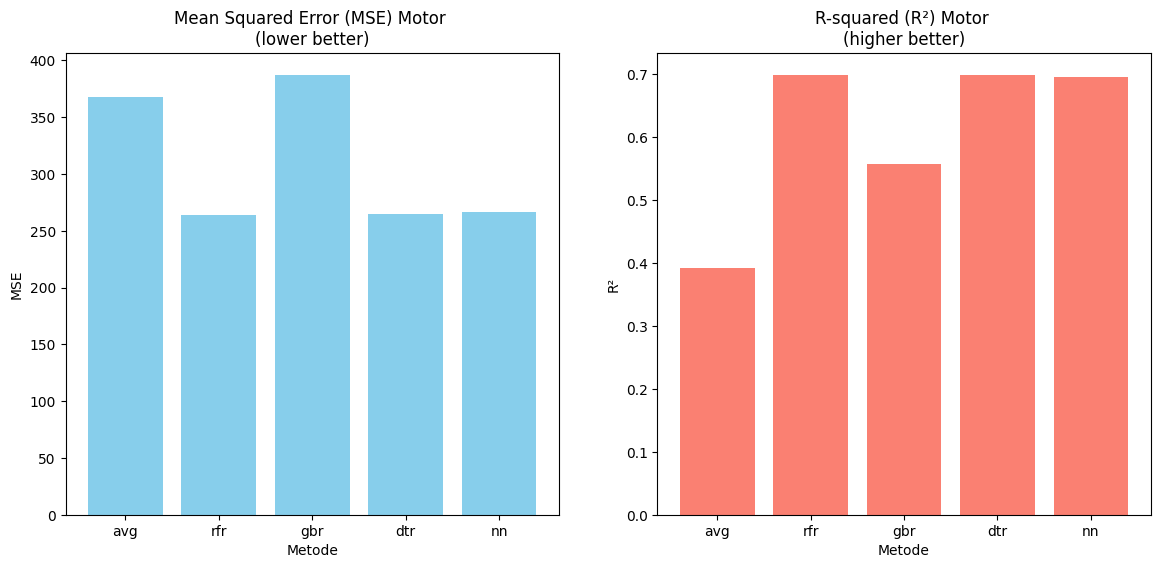

In [50]:
# Membuat figure dan dua subplot (untuk MSE dan R²)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot MSE
ax[0].bar(mses.keys(), mses.values(), color='skyblue')
ax[0].set_title('Mean Squared Error (MSE) Motor \n(lower better)')
ax[0].set_xlabel('Metode')
ax[0].set_ylabel('MSE')

# Plot R²
ax[1].bar(r2s.keys(), r2s.values(), color='salmon')
ax[1].set_title('R-squared (R²) Motor \n(higher better)')
ax[1].set_xlabel('Metode')
ax[1].set_ylabel('R²')

In [51]:
print(mses)
print(maes)
print(rmses)
print(r2s)

{'avg': 367.5399037354029, 'rfr': 263.4323547636821, 'gbr': 387.32684165721537, 'dtr': 264.48401484525294, 'nn': 266.2955277284563}
{'avg': 12.970863052275499, 'rfr': 12.022467492796908, 'gbr': 15.483993747956504, 'dtr': 12.059616326073069, 'nn': 12.107346746842206}
{'avg': 19.171330254716363, 'rfr': 16.230599334703637, 'gbr': 19.68062096726664, 'dtr': 16.262964515894787, 'nn': 16.318563899083042}
{'avg': 0.39227207111799967, 'rfr': 0.6995992756913997, 'gbr': 0.5583182487877492, 'dtr': 0.6984000325289046, 'nn': 0.6963343038043641}


In [52]:
# Gabungkan tabel berdasarkan kolom "Actual"
result = data_avg.merge(data_rfr[['Predicted_rfr','Residual_rfr']], left_index=True, right_index=True) \
                 .merge(data_gbr[['Predicted_gbr','Residual_gbr']], left_index=True, right_index=True) \
                 .merge(data_dtr[['Predicted_dtr','Residual_dtr']], left_index=True, right_index=True) \
                 .merge(data_nn[['Predicted_nn','Residual_nn']], left_index=True, right_index=True)
result.head()

,Actual,Predicted_avg,Residual_avg,Predicted_rfr,Residual_rfr,Predicted_gbr,Residual_gbr,Predicted_dtr,Residual_dtr,Predicted_nn,Residual_nn
0,76,79.857143,-3.857143,84.387837,4.612163,75.925242,13.074758,88.231560,0.768440,85.455437,3.544563
1,37,67.222222,-30.222222,63.091821,-49.091821,59.054040,-45.054040,63.111111,-49.111111,73.686508,-59.686508
2,51,62.575758,-11.575758,48.893515,-8.893515,48.245429,-8.245429,48.606061,-8.606061,48.458233,-8.458233
3,77,90.689655,-13.689655,88.224010,-5.224010,75.925242,7.074758,84.799607,-1.799607,85.455437,-2.455437
4,50,58.333333,-8.333333,48.409487,-4.409487,49.040672,-5.040672,48.393939,-4.393939,46.889309,-2.889309


In [53]:
import seaborn as sns

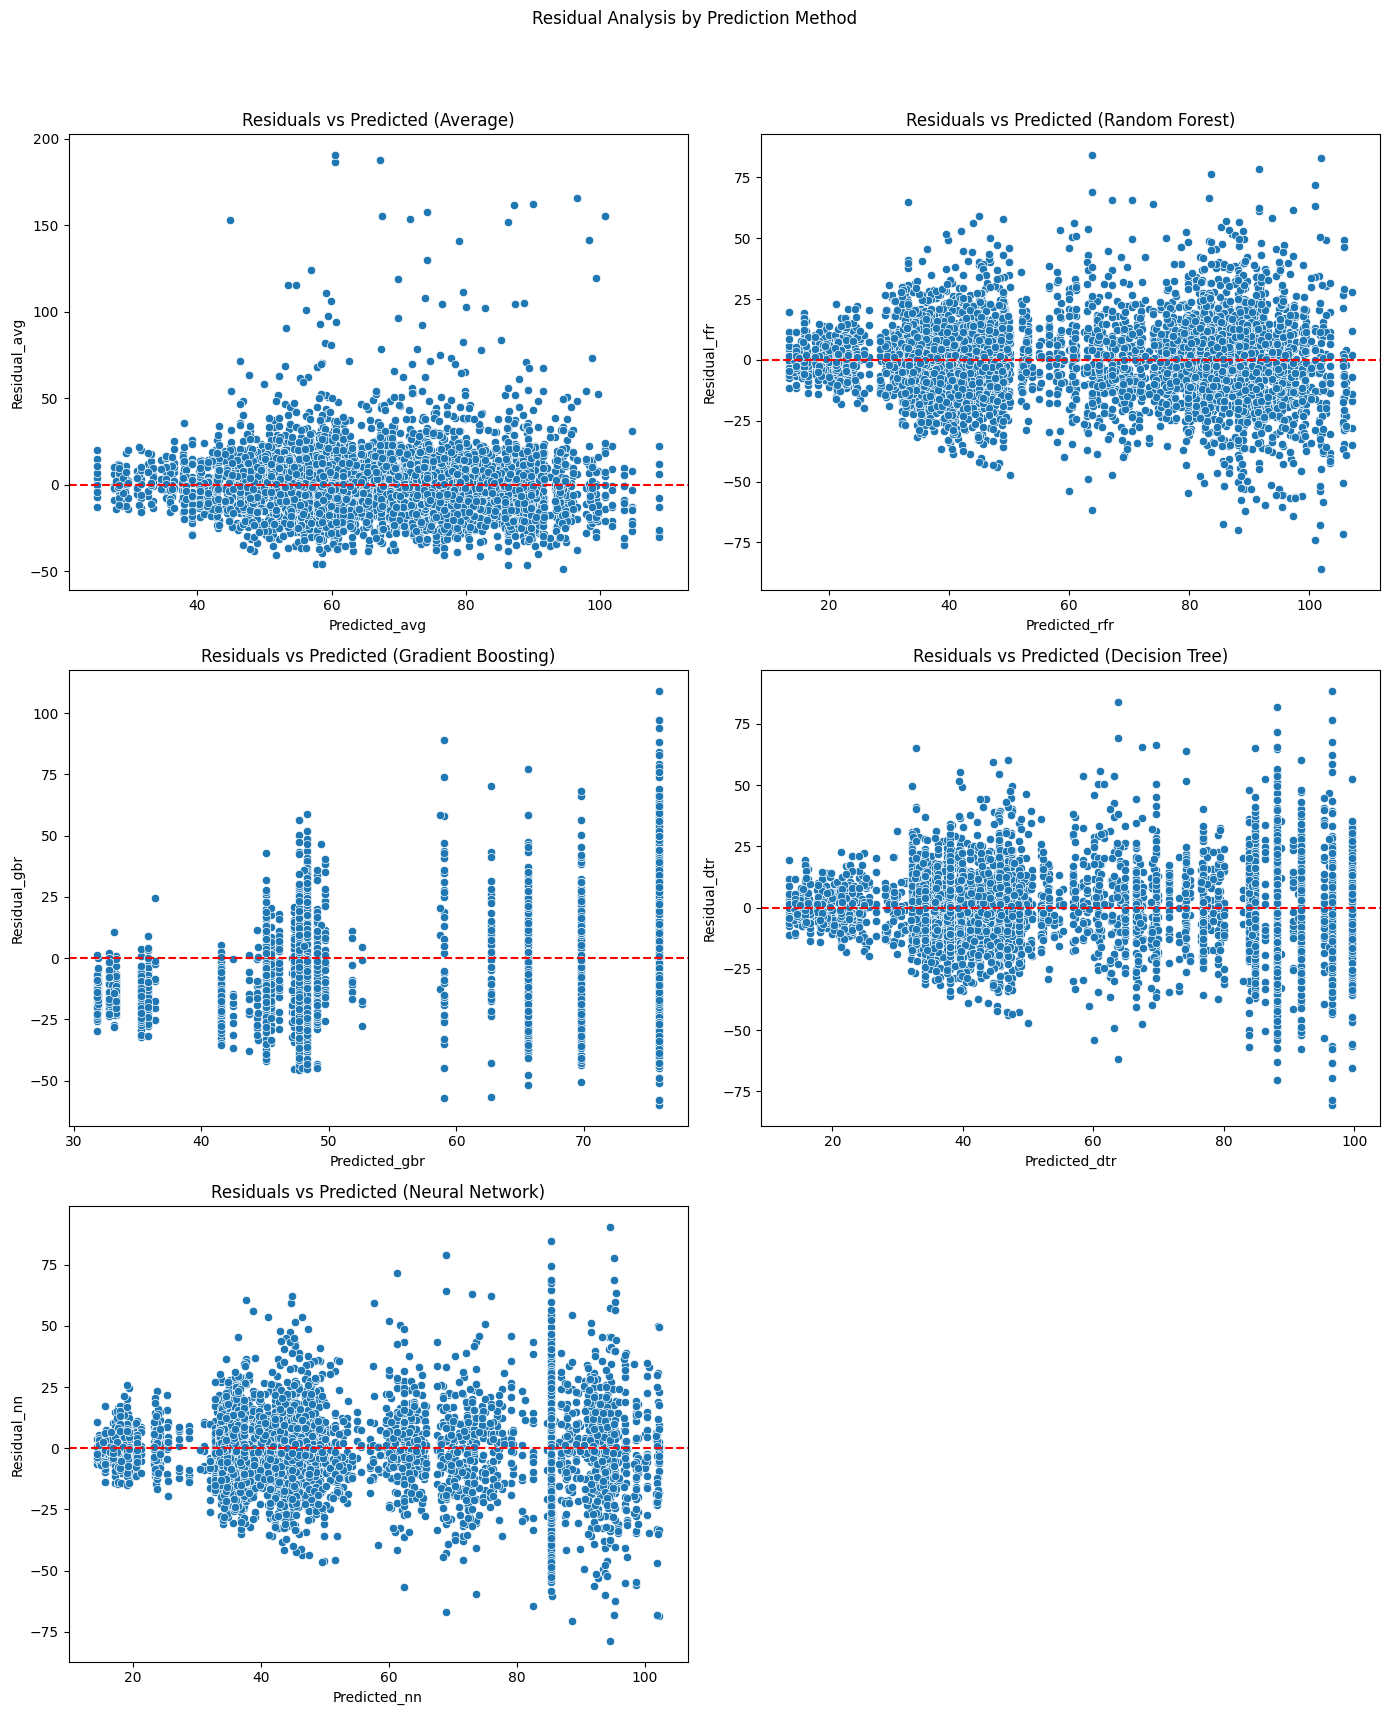

In [54]:
# Creating a DataFrame
df = result.copy()

# Set up the plot grid
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
fig.suptitle('Residual Analysis by Prediction Method')

# Scatter plot for each model's residuals
sns.scatterplot(x=df['Predicted_avg'], y=df['Residual_avg'], ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals vs Predicted (Average)')
axes[0, 0].set_xlabel('Predicted_avg')
axes[0, 0].set_ylabel('Residual_avg')

sns.scatterplot(x=df['Predicted_rfr'], y=df['Residual_rfr'], ax=axes[0, 1])
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title('Residuals vs Predicted (Random Forest)')
axes[0, 1].set_xlabel('Predicted_rfr')
axes[0, 1].set_ylabel('Residual_rfr')

sns.scatterplot(x=df['Predicted_gbr'], y=df['Residual_gbr'], ax=axes[1, 0])
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals vs Predicted (Gradient Boosting)')
axes[1, 0].set_xlabel('Predicted_gbr')
axes[1, 0].set_ylabel('Residual_gbr')

sns.scatterplot(x=df['Predicted_dtr'], y=df['Residual_dtr'], ax=axes[1, 1])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Residuals vs Predicted (Decision Tree)')
axes[1, 1].set_xlabel('Predicted_dtr')
axes[1, 1].set_ylabel('Residual_dtr')

sns.scatterplot(x=df['Predicted_nn'], y=df['Residual_nn'], ax=axes[2, 0])
axes[2, 0].axhline(0, color='red', linestyle='--')
axes[2, 0].set_title('Residuals vs Predicted (Neural Network)')
axes[2, 0].set_xlabel('Predicted_nn')
axes[2, 0].set_ylabel('Residual_nn')

# Hide the last empty plot (since we have an odd number of plots)
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()